<a href="https://colab.research.google.com/github/rodrigodemend/Previsao_Covid/blob/main/Notebooks/Previs%C3%A3o_das_mortes_por_Covid_19_usando_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando todas as bibliotecas

In [139]:
!pip install prophet

In [140]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from sklearn.model_selection import ParameterGrid
from pandas.plotting import autocorrelation_plot
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Importando os dados limpos

In [141]:
data_new_deaths = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Cleaned/data_new_deaths.csv', encoding='utf-8')
data_new_deaths.head()

,date,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


#Funções utilizadas no notebook

In [142]:
def prophet_model(df, parameters=None, sazon=False, sazon_param=None, i=0, country_holidays=False):
  """
  Função criada para facilitar a criação do modelo com novos parâmetros e teste com cross validation
  """
  if parameters != None:
    modelo = Prophet(**parameters)
  else:
    modelo = Prophet()
  if sazon:
    modelo.add_seasonality(name='sazon_'+str(i), **sazon_param)
  if country_holidays:
    modelo.add_country_holidays(country_name='BR')
  modelo.fit(df)
  df_cv = cross_validation(modelo, initial='400 days', period='30 days', horizon='30 days')
  return performance_metrics(df_cv), modelo

In [143]:
def prophet_model_grid(df, grid):
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(grid)):
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=grid[i])
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [144]:
def prophet_model_grid_sazon(df, param, grid):
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(grid)):
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=param, sazon=True, sazon_param=grid[i], i=i)
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [145]:
def prophet_model_country_holidays(df, parameters, country_holidays, holidays_prior_scale_list):
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(holidays_prior_scale_list)):
    parameters['holidays_prior_scale'] = holidays_prior_scale_list[i]
    print('======================= '+str(i)+' ====================================')
    df_p, _ = prophet_model(df, parameters=parameters, country_holidays=country_holidays)
    MAE[str(i)] = df_p['mae']
    RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [146]:
def prophet_model_holidays(df, parameters, holidays, prior_scale, initial_i=0, initial_j=0, jump=None):
  MAE = pd.DataFrame({'holiday': [], 'prior_scale': [], 'MAE_Mean': []})
  RMSE = pd.DataFrame({'holiday': [], 'prior_scale': [], 'RMSE_Mean': []})
  nome_feriados = list(holidays['holiday'].unique())
  for i in range(initial_i, len(nome_feriados)):
    df_holidays = holidays[holidays['holiday'] == nome_feriados[i]].copy()
    for j in range(initial_j, len(prior_scale)):
      check_jump = jump_function(jump, nome_feriados[i], prior_scale[j])
      if check_jump == False:
        df_holidays['prior_scale'] = prior_scale[j]
        parameters['holidays'] = df_holidays
        print('======================= '+str(nome_feriados[i])+' '+str(prior_scale[j])+' ====================================')
        df_p, _ = prophet_model(df, parameters=parameters)
        MAE.loc[len(MAE)] = [nome_feriados[i], prior_scale[j], round(df_p['mae'].mean(),2)]
        RMSE.loc[len(RMSE)] = [nome_feriados[i], prior_scale[j], round(df_p['rmse'].mean(),2)]
    initial_j = 0
  return MAE, RMSE

In [147]:
def prophet_model_combination_holidays(df, parameters, df_holidays, prior_scale_table, combination_holidays, jump_combination=None):
  MAE = pd.DataFrame()
  RMSE = pd.DataFrame()
  for i in range(len(combination_holidays)):
    if (i in jump_combination) == False:
      selected_holidays = df_holidays[df_holidays['holiday'].isin(combination_holidays[i])].merge(prior_scale_table, on='holiday', how='left')
      parameters['holidays'] = selected_holidays
      print('======================= '+str(i)+' ====================================')
      df_p, _ = prophet_model(df, parameters=parameters)
      MAE[str(i)] = df_p['mae']
      RMSE[str(i)] = df_p['rmse']
  return MAE, RMSE

In [148]:
def best_result(df, grid):
  """
  Esta função retorna o melhor resultado 
  """
  return grid[int(df.mean().sort_values().head(1).index[0])]

In [149]:
def print_changepoints(model):
  """
  Essa função serve para plotar os changepoints usados pelo modelo
  """
  dataframefuturo = model.make_future_dataframe(periods=30)
  dataframefuturo['cap'] = 300
  previsao = model.predict(dataframefuturo)
  fig = model.plot(previsao)
  a = add_changepoints_to_plot(fig.gca(), model, previsao)

In [150]:
def jump_function(dic, key, value):
  # Verifica se a chave atual existe no dicionario
  check = False
  for i in dic.keys():
    if i == key:
      check = True
  # Se a chave existir, verifica se o valor dessa chave está no dicionario
  if check:
    if value in dic[key]:
      return True
  return False

In [151]:
def grid_list(in_list, label_never_used='label_never_used'):
  # Construindo uma tabela verdade da lista de entrada
  truth_table = pd.DataFrame()
  for i in range(len(in_list)):
    truth_table[str(i)] = [label_never_used if k % (2**(i+1)) < (2**(i+1))/2 else in_list[i] for k in range(2**len(in_list))]
  # Eliminando a primeira linha que não tem nenhum valor da lista
  truth_table.drop([0], inplace=True)
  # Criando a lista com todas as combinações
  combination_list = []
  for i in range(len(truth_table)):
    aux_combination_list = []
    for j in list(truth_table.iloc[i].values):
      if j != label_never_used:
        aux_combination_list.append(j)
    combination_list.append(aux_combination_list)
  return combination_list

# Visualização dos dados

In [152]:
estado = 'SC'

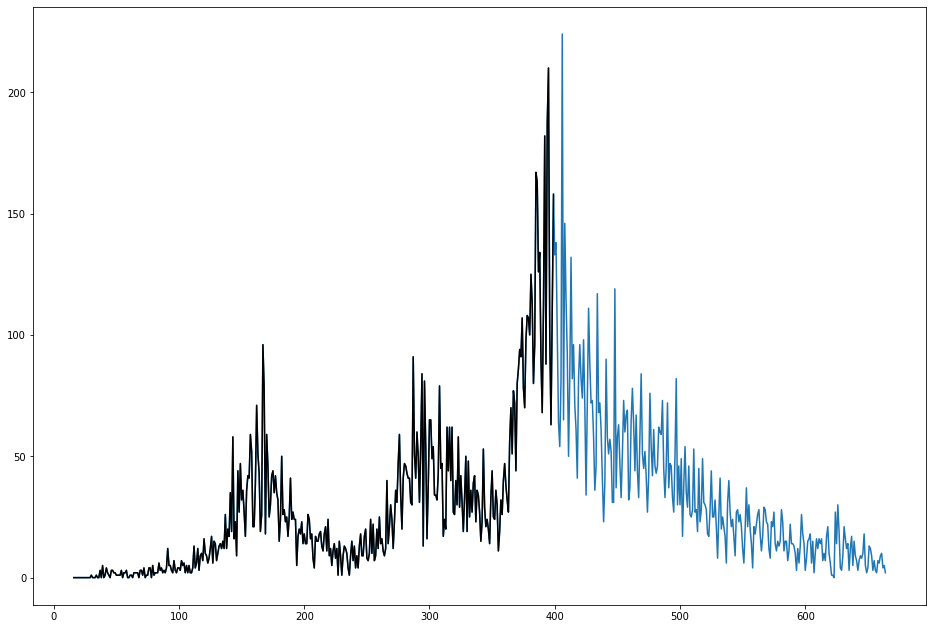

In [153]:
data_new_deaths[estado].plot(figsize=(16,11))
data_new_deaths[estado][:400].plot(figsize=(16,11), color='black')

In [154]:
data_new_deaths[estado].describe()

count    649.000000
mean      31.018490
std       32.198453
min        0.000000
25%        9.000000
50%       21.000000
75%       43.000000
max      224.000000
Name: SC, dtype: float64

## Modelo básico Prophet

In [155]:
df = pd.DataFrame()
df['ds'] = data_new_deaths['date']
df['y'] = data_new_deaths[estado].values
df['cap'] = 300

In [156]:
df_p, _ = prophet_model(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


In [157]:
print("Média MAE:", df_p['mae'].mean()) 
print("Média RMSE:", df_p['rmse'].mean())

Média MAE: 21.599716541393395
Média RMSE: 28.938175969140595


# Otimizando a tendência

Criando os dataframes para salvar os resultados dos experimentos da tendência

In [158]:
MAE_results_exp_trend = pd.DataFrame()
RMSE_results_exp_trend = pd.DataFrame()

## 1° Experimento de tendência

Fazendo uma otimização do parâmetro "changepoint_prior_scale" com os "n_changepoints" gerados automáticamente pelo prophet 

In [159]:
params_grid = {'n_changepoints':[i for i in range(5, 55, 5)],
              'changepoint_prior_scale':[i/1000 for i in range(1, 500, 20)],
               'growth':['linear', 'logistic']}
grid = ParameterGrid(params_grid)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp1/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [160]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

Salvando os resultados de MAE e RMSE

In [161]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Tanto para o MAE quanto para o RMSE foram escolhidos o mesmo conjunto de parametros:

In [162]:
param = best_result(MAE, grid)
param

{'changepoint_prior_scale': 0.001, 'growth': 'logistic', 'n_changepoints': 50}

In [163]:
best_result(RMSE, grid)

{'changepoint_prior_scale': 0.001, 'growth': 'logistic', 'n_changepoints': 50}

Visualizando os changepoints

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


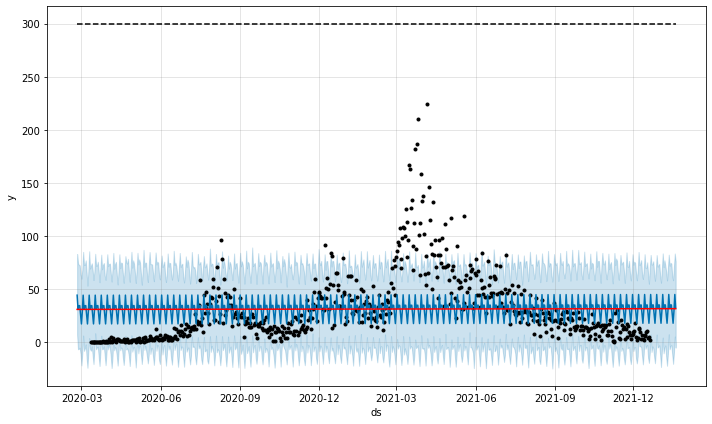

In [164]:
results, modelo = prophet_model(df, parameters=param)
print_changepoints(modelo)

Salvando os resultados do primeiro experimento

In [165]:
MAE_results_exp_trend['1° Exp'] = results['mae']
RMSE_results_exp_trend['1° Exp'] = results['rmse']

In [166]:
print("Resultados do primeiro experimento - MAE: ", round(MAE_results_exp_trend['1° Exp'].mean(),2))
print("Resultados do primeiro experimento - RMSE: ", round(RMSE_results_exp_trend['1° Exp'].mean(),2))

Resultados do primeiro experimento - MAE:  15.3
Resultados do primeiro experimento - RMSE:  20.13


## 2° Experimento de tendência

experimento de pegar diferenças muito grandes como changepoints

In [167]:
df_diff = df.copy()
df_diff['diff'] = df_diff['y'].diff()
dates = [i for i in df_diff.query('(diff < -50) or (diff > 50)')['ds']]
dates

['2020-08-10',
 '2020-08-12',
 '2020-12-08',
 '2020-12-16',
 '2020-12-17',
 '2021-03-16',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-27',
 '2021-04-06',
 '2021-04-07',
 '2021-04-08',
 '2021-05-04',
 '2021-05-11',
 '2021-05-18',
 '2021-05-19',
 '2021-07-07']

Rodando com as datas achadas

In [168]:
param = {'changepoint_prior_scale' : [i/1000 for i in range(1, 500, 20)],
         'changepoints':[dates],
         'growth':['linear', 'logistic']}
grid = ParameterGrid(param)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp2/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp2/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [169]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

Salvando os resultados de MAE e RMSE

In [170]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Achando os melhores resultados do segundo experimento para o MAE e para o RMSE

In [171]:
param = best_result(df=MAE, grid=grid)
param

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-08-10',
  '2020-08-12',
  '2020-12-08',
  '2020-12-16',
  '2020-12-17',
  '2021-03-16',
  '2021-03-23',
  '2021-03-24',
  '2021-03-25',
  '2021-03-27',
  '2021-04-06',
  '2021-04-07',
  '2021-04-08',
  '2021-05-04',
  '2021-05-11',
  '2021-05-18',
  '2021-05-19',
  '2021-07-07'],
 'growth': 'logistic'}

In [172]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'changepoint_prior_scale': 0.401,
 'changepoints': ['2020-08-10',
  '2020-08-12',
  '2020-12-08',
  '2020-12-16',
  '2020-12-17',
  '2021-03-16',
  '2021-03-23',
  '2021-03-24',
  '2021-03-25',
  '2021-03-27',
  '2021-04-06',
  '2021-04-07',
  '2021-04-08',
  '2021-05-04',
  '2021-05-11',
  '2021-05-18',
  '2021-05-19',
  '2021-07-07'],
 'growth': 'linear'}

Visualizando os changepoints do melhor resultado do MAE

In [173]:
results, modelo = prophet_model(df, parameters=param)
print("======== MAE ===============")
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))
results, modelo = prophet_model(df, parameters=param_rmse)
print("======== RMSE ===============")
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


======== MAE ===============
Melhor resultado MAE:  12.13
Melhor resultado RMSE:  21.54


INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


======== RMSE ===============
Melhor resultado MAE:  12.22
Melhor resultado RMSE:  15.89


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


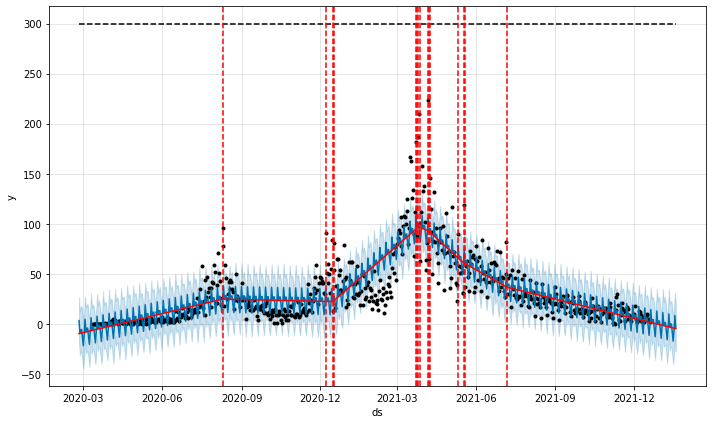

In [174]:
results, modelo = prophet_model(df, parameters=param_rmse)
print_changepoints(modelo)

Salvando os resultados do segundo experimento

In [175]:
MAE_results_exp_trend['2° Exp'] = results['mae']
RMSE_results_exp_trend['2° Exp'] = results['rmse']

In [176]:
print("Resultados do segundo experimento - MAE: ", round(MAE_results_exp_trend['2° Exp'].mean(),2))
print("Resultados do segundo experimento - RMSE: ", round(RMSE_results_exp_trend['2° Exp'].mean(),2))

Resultados do segundo experimento - MAE:  12.22
Resultados do segundo experimento - RMSE:  15.89


## 3° Experimento de tendência

['2020-06-15',
 '2020-08-11',
 '2020-10-19',
 '2020-12-09',
 '2021-02-15',
 '2021-03-27',
 '2021-07-08']

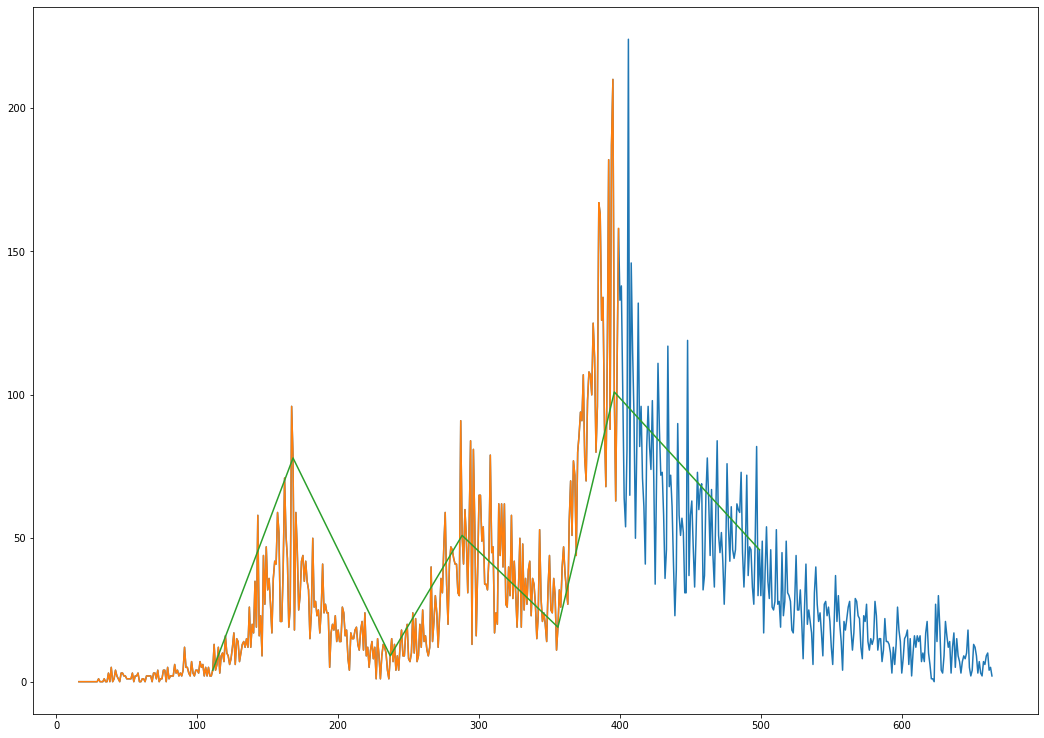

In [177]:
df_diff['y'].plot(figsize=(18,13))
df_diff['y'][:400].plot(figsize=(18,13))
dates2 = [111, 168, 237, 288, 356, 396, 499]
df_diff['y'].iloc[dates2].plot(figsize=(18,13))
dates2 = [df_diff['ds'][i] for i in dates2]
dates2

Rodando com as datas achadas

In [178]:
param = {'changepoint_prior_scale' : [i/1000 for i in range(1, 500, 20)],
         'changepoints':[dates2],
         'growth':['linear', 'logistic']}
grid = ParameterGrid(param)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp3/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Trend/Exp3/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [179]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [180]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Achando os melhores resultados do segundo experimento para o MAE e para o RMSE

In [181]:
param = best_result(df=MAE, grid=grid)
param

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic'}

In [182]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic'}

Visualizando os changepoints do melhor resultado do MAE

In [183]:
results, modelo = prophet_model(df, parameters=param)
print("======== MAE ===============")
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))
results, modelo = prophet_model(df, parameters=param_rmse)
print("======== RMSE ===============")
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


======== MAE ===============
Melhor resultado MAE:  9.85
Melhor resultado RMSE:  14.23


INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


======== RMSE ===============
Melhor resultado MAE:  9.85
Melhor resultado RMSE:  14.23


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


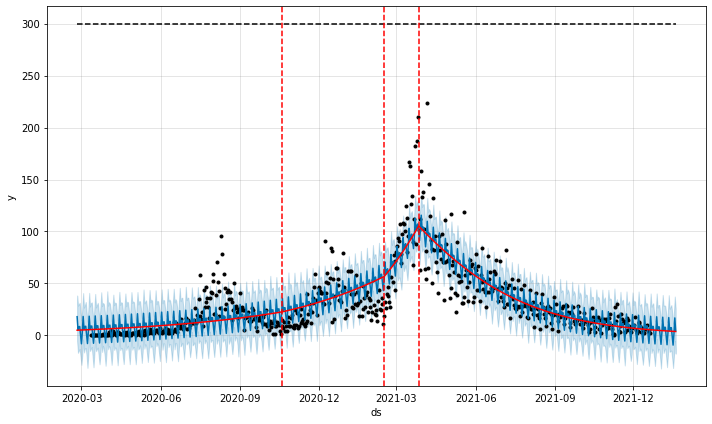

In [184]:
results, modelo = prophet_model(df, parameters=param)
print_changepoints(modelo)

Salvando os resultados do terceiro experimento

In [185]:
MAE_results_exp_trend['3° Exp'] = results['mae']
RMSE_results_exp_trend['3° Exp'] = results['rmse']

In [186]:
print("Resultados do terceiro experimento - MAE: ", round(MAE_results_exp_trend['3° Exp'].mean(),2))
print("Resultados do terceiro experimento - RMSE: ", round(RMSE_results_exp_trend['3° Exp'].mean(),2))

Resultados do terceiro experimento - MAE:  9.85
Resultados do terceiro experimento - RMSE:  14.23


## Resultado dos experimentos

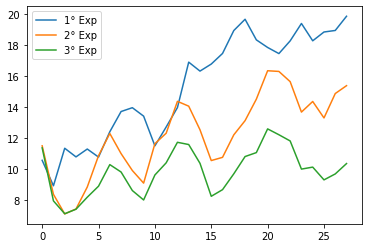

In [187]:
MAE_results_exp_trend.plot()

In [188]:
MAE_results_exp_trend.mean()

1° Exp    15.295139
2° Exp    12.218326
3° Exp     9.849959
dtype: float64

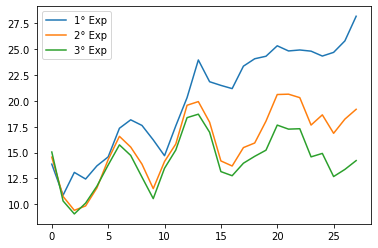

In [189]:
RMSE_results_exp_trend.plot()

In [190]:
RMSE_results_exp_trend.mean()

1° Exp    20.127960
2° Exp    15.888630
3° Exp    14.226306
dtype: float64

##Falar de contraste entre modelo básico com modelo otimizado a tendencia

Modelo básico:

In [191]:
print("Média MAE:", df_p['mae'].mean()) 
print("Média RMSE:", df_p['rmse'].mean())

Média MAE: 21.599716541393395
Média RMSE: 28.938175969140595


Modelo com a tendência otimizada:

In [192]:
print("Média MAE:", results['mae'].mean()) 
print("Média RMSE:", results['rmse'].mean())

Média MAE: 9.849959132701331
Média RMSE: 14.226305767425274


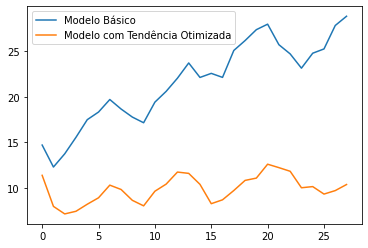

In [193]:
pd.DataFrame({"Modelo Básico": df_p['mae'],
              "Modelo com Tendência Otimizada": results['mae']}).plot()

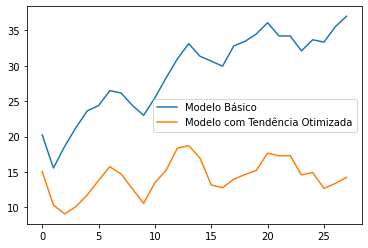

In [194]:
pd.DataFrame({"Modelo Básico": df_p['rmse'],
              "Modelo com Tendência Otimizada": results['rmse']}).plot()

# Otimizando Sazonalidade

Criando os dataframes para salvar os resultados dos experimentos da tendência

In [195]:
MAE_results_exp_sazon = pd.DataFrame()
RMSE_results_exp_sazon = pd.DataFrame()

## 1° Experimento de Sazonalidade

dizer que eu não sei exatamente o porque, mas o seasonality_mode = multiplicative não estava funcionando muito bem quando tinhamos valores de seasonality_prior_scale ou algumas combinações com valores baixos de weekly e yearly_seasonality. Então resolvi remover o seasonality_mode dessa parte do experimento, deixando como additive que é o default para poder testar os outros parâmetros.

In [196]:
params_grid = {'changepoint_prior_scale': [0.481],
 'changepoints': [['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08']],
 'growth': ['logistic'],
 'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0],
 'yearly_seasonality':[True, False, 5, 10, 15, 20, 25],
 'weekly_seasonality':[True, False, 5, 10, 15, 20, 25]}


grid = ParameterGrid(params_grid)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp1/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [197]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [198]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

In [199]:
param = best_result(df=MAE, grid=grid)
param

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 0.01,
 'weekly_seasonality': 10,
 'yearly_seasonality': False}

In [200]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 0.01,
 'weekly_seasonality': 10,
 'yearly_seasonality': False}

Fazendo alguns experimentos com o modo multiplicativo, pois não pude adicionar ele no grid

In [201]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

results, modelo = prophet_model(df, parameters=param)
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


Melhor resultado MAE:  7.62
Melhor resultado RMSE:  10.76


Visualizando os changepoints do melhor resultado do MAE

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


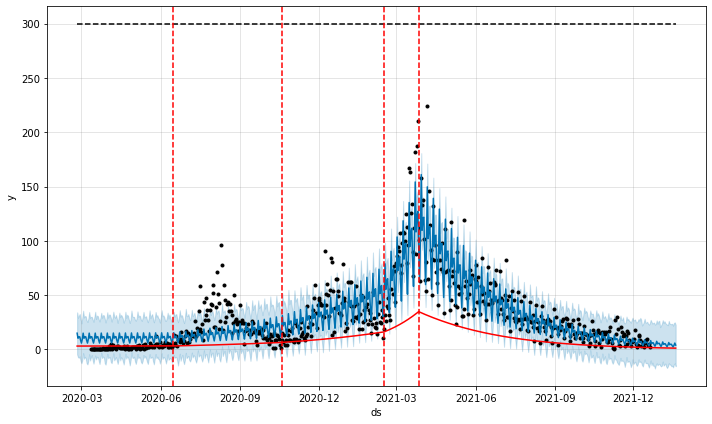

In [202]:
results, modelo = prophet_model(df, parameters=param)
print_changepoints(modelo)

Salvando os resultados do primeiro experimento

In [203]:
MAE_results_exp_sazon['1° Exp'] = results['mae']
RMSE_results_exp_sazon['1° Exp'] = results['rmse']

In [204]:
print("Resultados do primeiro experimento - MAE: ", round(MAE_results_exp_sazon['1° Exp'].mean(),2))
print("Resultados do primeiro experimento - RMSE: ", round(RMSE_results_exp_sazon['1° Exp'].mean(),2))

Resultados do primeiro experimento - MAE:  7.62
Resultados do primeiro experimento - RMSE:  10.76


## 2° Experimento de Sazonalidade

Verificando autocorrelação

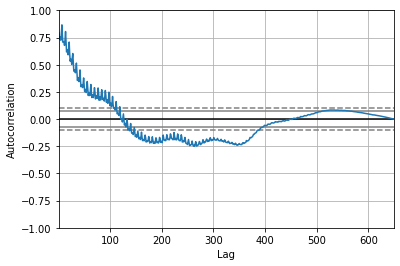

In [205]:
autocorrelation_plot(df['y'][16:])

Retirando algumas possiveis sazonalidades para teste

In [206]:
possiveis_sazonalidades = [7, 14, 21, 30.5, 45, 60, 75, 90, 170, 260, 350]

In [207]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'additive'}

params_grid = {'period':possiveis_sazonalidades,
              'fourier_order':[5, 10, 15, 20, 25]}

grid = ParameterGrid(params_grid)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid_sazon(df[16:], param, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp2/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Seasonality/Exp2/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [208]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [209]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

In [210]:
param = best_result(df=MAE, grid=grid)
param

{'fourier_order': 25, 'period': 90}

In [211]:
param_rmse = best_result(df=RMSE, grid=grid)
param_rmse

{'fourier_order': 15, 'period': 90}

In [212]:
MAE.mean().sort_values().head(5)

51    13.423929
29    13.627143
27    14.846786
10    18.779643
34    19.344286
dtype: float64

Como podemos ver acima, os resultados foram bem piores do que do primeiro experimento. Mesmo fazendo alguns testes com o modo multiplicativo não foram achados nenhuma combinação que atinja o resultado do primeiro experimento de sazonalidade.

##Falar de contraste entre modelo básico, modelo com tendencia otimizada e modelo com sazonalidade otimizada 

Modelo básico:

In [213]:
print("Média MAE:", df_p['mae'].mean()) 
print("Média RMSE:", df_p['rmse'].mean())

Média MAE: 21.599716541393395
Média RMSE: 28.938175969140595


Modelo com a tendência otimizada:

In [214]:
print("Média MAE:", MAE_results_exp_trend['3° Exp'].mean()) 
print("Média RMSE:", RMSE_results_exp_trend['3° Exp'].mean())

Média MAE: 9.849959132701331
Média RMSE: 14.226305767425274


Modelo com a sazonalidade otimizada:

In [215]:
print("Média MAE:", MAE_results_exp_sazon['1° Exp'].mean()) 
print("Média RMSE:", RMSE_results_exp_sazon['1° Exp'].mean())

Média MAE: 7.624492829345139
Média RMSE: 10.76264239798291


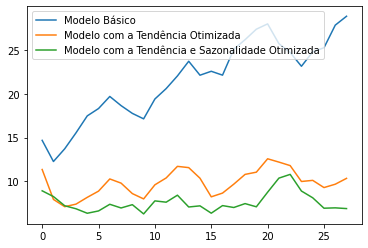

In [216]:
pd.DataFrame({"Modelo Básico": df_p['mae'],
              "Modelo com a Tendência Otimizada": MAE_results_exp_trend['3° Exp'],
              "Modelo com a Tendência e Sazonalidade Otimizada": MAE_results_exp_sazon['1° Exp']}).plot()

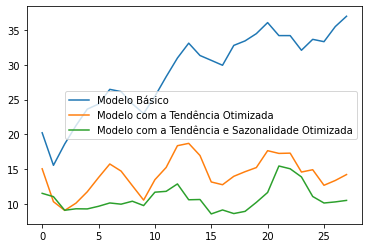

In [217]:
pd.DataFrame({"Modelo Básico": df_p['rmse'],
              "Modelo com a Tendência Otimizada": RMSE_results_exp_trend['3° Exp'],
              "Modelo com a Tendência e Sazonalidade Otimizada": RMSE_results_exp_sazon['1° Exp']}).plot()

# Otimizando os Feriados

In [218]:
MAE_results_exp_holidays = pd.DataFrame()
RMSE_results_exp_holidays = pd.DataFrame()

## 1° Experimento de Feriados

Testando com os feriados nacionais

In [219]:
holidays_prior_scale_list = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

enable = False
if enable:
  MAE, RMSE = prophet_model_country_holidays(df, parameters=param, country_holidays=True, holidays_prior_scale_list=holidays_prior_scale_list)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp1/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp1/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [220]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [221]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Verificando o resultado dos feriados nacionais

In [222]:
MAE.mean().sort_values().head(1)

5    7.645357
dtype: float64

In [223]:
RMSE.mean().sort_values().head(1)

6    10.878929
dtype: float64

Os feriados nacionais não influenciaram o suficiente a ponto de melhorar a performace do modelo

## 2° Experimento de Feriados

Buscando os feriados do estado de santa catarina

In [224]:
feriados = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Holidays_from_2020_2021_2022.txt', encoding="utf-8", sep=';')
feriados.head()

,ds,holiday
0,01/01/2020,Ano Novo
1,24/02/2020,Carnaval
2,25/02/2020,Carnaval
3,26/02/2020,Carnaval
4,10/04/2020,Sexta-Feira Santa


In [225]:
nome_feriados = list(feriados['holiday'].unique())
nome_feriados

['Ano Novo',
 'Carnaval',
 'Sexta-Feira Santa',
 'Dia de Tiradentes',
 'Dia do Trabalho',
 'Corpus Christi',
 'Independência do Brasil',
 'Nossa Senhora Aparecida',
 'Dia do Professor',
 'Dia do Servidor Público',
 'Dia de Finados',
 'Proclamação da República',
 'Natal']

### Parte 1: Selecionandos os feriados que melhoram a performace do modelo

Fazendo uma analise de cada feriado separadamente

In [226]:
prior_scale = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

initial_i = 0
initial_j = 0
jump_because_error = {'Dia do Trabalho': [5.0],
                      'Independência do Brasil': [0.05, 1.0],
                      'Dia do Professor': [0.1],
                      'Dia de Finados': [1.0],
                      'Proclamação da República': [10.0],
                      'Natal': [0.1, 5.0]}

enable = False
if enable:
  MAE, RMSE = prophet_model_holidays(df, parameters=param, holidays=feriados, prior_scale=prior_scale, initial_i=initial_i, initial_j=initial_j, jump=jump_because_error)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_1_MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_1_RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [227]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [228]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

Visualizando as combinações de feriados e prior scale que fizeram o modelo performar melhor

MAE

In [229]:
MAE.sort_values(by='MAE_Mean', inplace=True)
MAE[MAE['MAE_Mean'] < round(MAE_results_exp_sazon['1° Exp'].mean(),2)].drop_duplicates(subset='holiday')

,holiday,prior_scale,MAE_Mean
17,Sexta-Feira Santa,0.50,7.50
1,Ano Novo,0.05,7.56
51,Nossa Senhora Aparecida,5.00,7.58
80,Natal,0.50,7.59
59,Dia do Servidor Público,0.01,7.60
70,Dia de Finados,5.00,7.61


RMSE

In [230]:
RMSE.sort_values(by='RMSE_Mean', inplace=True)
RMSE[RMSE['RMSE_Mean'] < round(RMSE_results_exp_sazon['1° Exp'].mean(),2)].drop_duplicates(subset='holiday')

,holiday,prior_scale,RMSE_Mean
17,Sexta-Feira Santa,0.50,10.55
1,Ano Novo,0.05,10.68
80,Natal,0.50,10.71
51,Nossa Senhora Aparecida,5.00,10.72


Vamos apenas pegar os feriados que fizeram o modelo performar melhor nas duas métricas (MAE e RMSE).

No caso, será os mesmos feriados que foram filtrados do RMSE, uma vez que todos esses feriados também ajudam a melhorar a performace do MAE.

### Parte 2: Achando a melhor combinação dos feriados que melhoram a performace do modelo

Dataframe auxiliar para criar a coluna prior_scale

In [231]:
Aux_Feriados = RMSE[RMSE['RMSE_Mean'] < round(RMSE_results_exp_sazon['1° Exp'].mean(),2)].drop_duplicates(subset='holiday')
Aux_Feriados = Aux_Feriados[['holiday', 'prior_scale']]
Aux_Feriados

,holiday,prior_scale
17,Sexta-Feira Santa,0.50
1,Ano Novo,0.05
80,Natal,0.50
51,Nossa Senhora Aparecida,5.00


Selecionando os feriados que serão usados na criação do modelo:

In [232]:
feriados_selecionados = list(RMSE[RMSE['RMSE_Mean'] < round(RMSE_results_exp_sazon['1° Exp'].mean(),2)].drop_duplicates(subset='holiday')['holiday'])
feriados_selecionados

['Sexta-Feira Santa', 'Ano Novo', 'Natal', 'Nossa Senhora Aparecida']

Criando todas as combinação de todos os feriados selecionados

In [233]:
combinacao_de_feriados = grid_list(feriados_selecionados)
combinacao_de_feriados

[['Sexta-Feira Santa'],
 ['Ano Novo'],
 ['Sexta-Feira Santa', 'Ano Novo'],
 ['Natal'],
 ['Sexta-Feira Santa', 'Natal'],
 ['Ano Novo', 'Natal'],
 ['Sexta-Feira Santa', 'Ano Novo', 'Natal'],
 ['Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Nossa Senhora Aparecida'],
 ['Ano Novo', 'Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Ano Novo', 'Nossa Senhora Aparecida'],
 ['Natal', 'Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Natal', 'Nossa Senhora Aparecida'],
 ['Ano Novo', 'Natal', 'Nossa Senhora Aparecida'],
 ['Sexta-Feira Santa', 'Ano Novo', 'Natal', 'Nossa Senhora Aparecida']]

Dataframe com os feriados selecionados e seus prior scale:

In [234]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

jump_combination = [13]

enable = False
if enable:
  MAE, RMSE = prophet_model_combination_holidays(df, 
                                                 parameters=param, 
                                                 df_holidays=feriados, 
                                                 prior_scale_table=Aux_Feriados, 
                                                 combination_holidays=combinacao_de_feriados, 
                                                 jump_combination=jump_combination)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_2_MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp2/Part_2_RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [235]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [236]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

As 4 melhores combinações foram as 4 combinações onde tem apenas 1 feriado selecionado

In [237]:
for i in MAE.mean().sort_values().head(10).index:
  print(combinacao_de_feriados[int(i)])

['Sexta-Feira Santa']
['Ano Novo']
['Nossa Senhora Aparecida']
['Natal']
['Sexta-Feira Santa', 'Nossa Senhora Aparecida']
['Sexta-Feira Santa', 'Ano Novo']
['Ano Novo', 'Natal']
['Sexta-Feira Santa', 'Natal', 'Nossa Senhora Aparecida']
['Ano Novo', 'Nossa Senhora Aparecida']
['Sexta-Feira Santa', 'Ano Novo', 'Natal', 'Nossa Senhora Aparecida']


In [238]:
for i in RMSE.mean().sort_values().head(10).index:
  print(combinacao_de_feriados[int(i)])

['Sexta-Feira Santa']
['Ano Novo']
['Natal']
['Nossa Senhora Aparecida']
['Sexta-Feira Santa', 'Nossa Senhora Aparecida']
['Sexta-Feira Santa', 'Ano Novo']
['Ano Novo', 'Natal']
['Sexta-Feira Santa', 'Natal', 'Nossa Senhora Aparecida']
['Natal', 'Nossa Senhora Aparecida']
['Ano Novo', 'Nossa Senhora Aparecida']


Isso para mim não faz muito sentido uma vez que separados eles melhoram a performace do modelo e cada feriado vai influenciar em sua data especifica. Portanto se justassemos uma combinação deles, deveriamos ter um resultado melhor do que eles indivualmente. 

O experimento não resultou como imaginado, mas tivemos uma melhora na performace do modelo adicionando o feridado de Sexta-Feira Santa ao modelo. 

Rodando o modelo com o feriado de Sexta-Feira Santa

In [239]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative'}

# Criando a tabela de feriados
selected_holidays = feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')
param['holidays'] = selected_holidays

results, modelo = prophet_model(df, parameters=param)
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


Melhor resultado MAE:  7.5
Melhor resultado RMSE:  10.55


Salvando os resultados do segundo experimento

In [240]:
MAE_results_exp_holidays['2° Exp'] = results['mae']
RMSE_results_exp_holidays['2° Exp'] = results['rmse']

In [241]:
print("Resultados do segundo experimento - MAE: ", round(MAE_results_exp_holidays['2° Exp'].mean(),2))
print("Resultados do segundo experimento - RMSE: ", round(RMSE_results_exp_holidays['2° Exp'].mean(),2))

Resultados do segundo experimento - MAE:  7.5
Resultados do segundo experimento - RMSE:  10.55


## 3° Experimento de Feriados

Experimento em que eu passe todos os feriados de santa catarina e ache o melhor holidays_prior_scale para todos

In [242]:
params_grid = {'changepoint_prior_scale': [0.481],
 'changepoints': [['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08']],
 'growth': ['logistic'],
 'seasonality_prior_scale': [1.0],
 'weekly_seasonality': [10],
 'yearly_seasonality': [False],
 'seasonality_mode': ['multiplicative'],
 'holidays': [feriados], 
 'holidays_prior_scale': [0.010, 0.025, 0.050, 0.075, 0.100, 0.250, 0.500, 0.750, 1.0, 2.5, 5.0, 7.5, 10.0]}

grid = ParameterGrid(params_grid)

enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp3/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp3/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [243]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [244]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

In [245]:
MAE.mean().sort_values()

12     7.657857
2      7.691071
11     7.695000
0      7.698571
1      7.710357
3      7.716786
7      7.722857
8      7.723214
9      7.739286
6      7.767143
10     7.781071
4      7.840714
5     13.791071
dtype: float64

In [246]:
RMSE.mean().sort_values()

12    10.820357
11    10.895714
2     10.900714
0     10.912857
3     10.917143
1     10.921429
8     10.965714
7     10.971071
9     10.980357
6     11.020000
10    11.100714
4     11.157143
5     23.720000
dtype: float64

Não achamos um prior_scale que melhorasse o desempenho do modelo

## 4° Experimento de Feriados

Criando um evento especifico para dia da semana e um fim de semana e tentando otimizar o prior_scale

In [247]:
map_day_of_week = {'Monday': 'business_day',
                   'Tuesday': 'business_day',
                   'Wednesday': 'business_day',
                   'Thursday': 'business_day',
                   'Friday': 'business_day',
                   'Saturday': 'weekend',
                   'Sunday': 'weekend'}

df_business_day = pd.DataFrame()
df_business_day['ds'] = df['ds']
df_business_day['Day_of_Week'] = pd.to_datetime(df['ds']).dt.day_name()
df_business_day['holiday'] = df_business_day['Day_of_Week'].map(map_day_of_week)
df_business_day.drop(columns = ['Day_of_Week'], inplace=True)
df_business_day.head(10)

,ds,holiday
0,2020-02-25,business_day
1,2020-02-26,business_day
2,2020-02-27,business_day
3,2020-02-28,business_day
4,2020-02-29,weekend
5,2020-03-01,weekend
6,2020-03-02,business_day
7,2020-03-03,business_day
8,2020-03-04,business_day
9,2020-03-05,business_day


Criando a lista de dataframes com as combinações de prior_scale para dias da semana e fins de semana

In [248]:
holidays_list = {'business_day': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
                 'weekend': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
holidays_grid = ParameterGrid(holidays_list)
list_of_df_holidays = []
for i in range(len(holidays_grid)):
  df_business_day['prior_scale'] = df_business_day['holiday'].map(holidays_grid[i])
  list_of_df_holidays.append(df_business_day.copy())

In [249]:
params_grid = {'changepoint_prior_scale': [0.481],
 'changepoints': [['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08']],
 'growth': ['logistic'],
 'seasonality_prior_scale': [1.0],
 'weekly_seasonality': [10],
 'yearly_seasonality': [False],
 'seasonality_mode': ['multiplicative'],
 'holidays': list_of_df_holidays}

grid = ParameterGrid(params_grid)

# Removendo grid que dão erro devido ao seasonality_mode=multiplicative
error_grid = [16, 36, 37, 42, 47]
grid_without_error = []
for i in range(len(grid)):
  if (i in error_grid) == False:
    grid_without_error.append(grid[i])


enable = False
if enable:
  MAE, RMSE = prophet_model_grid(df, grid_without_error)
else:
  MAE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp4/MAE.csv', sep=',')
  RMSE = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Holidays/Exp4/RMSE.csv', sep=',')

Arrendondando os resultados de MAE e RMSE

In [250]:
MAE = round(MAE,2)
RMSE = round(RMSE,2)

In [251]:
MAE.to_csv('/content/MAE.csv', sep=',',  index=False)
RMSE.to_csv('/content/RMSE.csv', sep=',',  index=False)

In [252]:
MAE.mean().sort_values().head(10)

11    7.551786
6     7.586071
40    7.590357
18    7.626429
35    7.627500
25    7.630357
4     7.638214
21    7.663214
10    7.664643
28    7.666786
dtype: float64

In [253]:
RMSE.mean().sort_values().head(10)

11    10.686786
6     10.698571
40    10.748214
18    10.793571
35    10.801786
4     10.802500
25    10.816786
14    10.847857
13    10.847857
38    10.859286
dtype: float64

Esse experimento também não obteve um resultador melhor que o resultado do experimento 2

# Otimizando os Outliers


In [254]:
MAE_results_exp_outliers = pd.DataFrame()
RMSE_results_exp_outliers = pd.DataFrame()

Treinando nosso melhor modelo até o momento

In [261]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative',
 'holidays': feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')}

results, modelo = prophet_model(df, parameters=param)
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


Melhor resultado MAE:  7.5
Melhor resultado RMSE:  10.55


Retirando os outliers que estão fora do intervalo de confiança do nosso melhor modelo

In [271]:
enable = False
if enable:
  previsao = modelo.predict(df)
  df_sem_outliers = df[(df['y'] > previsao['yhat_lower']) & (df['y'] < previsao['yhat_upper'])]
  len(df_sem_outliers)
else:
  df_sem_outliers = pd.read_csv('https://raw.githubusercontent.com/rodrigodemend/Previsao_Covid/main/Dados/Experiments/Outliers/df_sem_outliers.csv', sep=',')

Vendo o resultado do modelo sem outliers

In [272]:
param = {'changepoint_prior_scale': 0.481,
 'changepoints': ['2020-06-15',
  '2020-08-11',
  '2020-10-19',
  '2020-12-09',
  '2021-02-15',
  '2021-03-27',
  '2021-07-08'],
 'growth': 'logistic',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': 10,
 'yearly_seasonality': False,
 'seasonality_mode': 'multiplicative',
 'holidays': feriados[feriados['holiday'] == 'Sexta-Feira Santa'].merge(Aux_Feriados, on='holiday', how='left')}

results, modelo = prophet_model(df_sem_outliers, parameters=param)
print("Melhor resultado MAE: ", round(results['mae'].mean(),2))
print("Melhor resultado RMSE: ", round(results['rmse'].mean(),2))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2021-04-24 00:00:00 and 2021-11-20 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Skipping MAPE because y close to 0


Melhor resultado MAE:  5.59
Melhor resultado RMSE:  7.44


Conseguimos melhor significamente a performace do modelo

In [264]:
MAE_results_exp_outliers['1° Exp'] = round(results['mae'], 2)
RMSE_results_exp_outliers['1° Exp'] = round(results['rmse'], 2)

Salvando o dataframe sem outliers

In [270]:
df_sem_outliers.to_csv('/content/df_sem_outliers.csv', sep=',', index=False)

# Comparação dos modelos criados

Visualizando o resultado pelo mean absolut error (MAE)

In [266]:
df_results_MAE = pd.DataFrame()
df_results_MAE['Básico'] = df_p['mae']
df_results_MAE['Tendência'] = MAE_results_exp_trend['3° Exp']
df_results_MAE['Sazonalidade'] = MAE_results_exp_sazon['1° Exp']
df_results_MAE['Feriados'] = MAE_results_exp_holidays['2° Exp']
df_results_MAE['Outliers'] = MAE_results_exp_outliers['1° Exp']

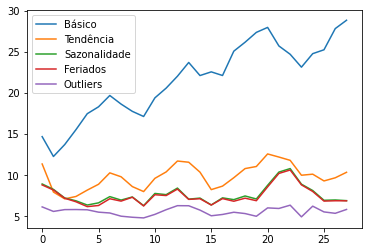

In [267]:
df_results_MAE.plot()

Visualizando o resultado pelo root mean squared error (RMSE)

In [268]:
df_results_RMSE = pd.DataFrame()
df_results_RMSE['Básico'] = df_p['rmse']
df_results_RMSE['Tendência'] = RMSE_results_exp_trend['3° Exp']
df_results_RMSE['Sazonalidade'] = RMSE_results_exp_sazon['1° Exp']
df_results_RMSE['Feriados'] = RMSE_results_exp_holidays['2° Exp']
df_results_RMSE['Outliers'] = RMSE_results_exp_outliers['1° Exp']

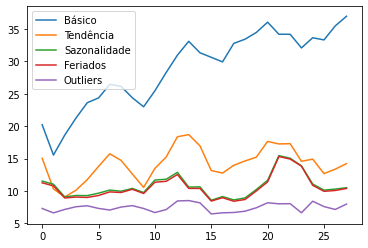

In [269]:
df_results_RMSE.plot()